In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import decoupler as dc
import scanpy as sc
import anndata as ad
sns.set_context("paper", font_scale=2) # set some nice global plotting settings.
from scipy.stats import zscore
import PyComplexHeatmap as pch
from scipy.stats import ks_2samp


In [71]:
mean_expr_cutoff = 0.5
gsi_cutoff =  0.5

def geno_norm(pdata, celltype):
    test = pdata[pdata.obs['subtype']==celltype].to_df()
    test = test.loc[:,test.mean() > mean_expr_cutoff]
    #print(test.shape, flush = True)
    #print(test.head(), flush = True)
    
    norm_pb = test/test.max(axis = 0) 
    
    return norm_pb


def gsi_calc(df):
    result = {}
    num_genotypes = df.shape[0]
    #print(num_genotypes)

    for col in df.columns:
            result[col] = sum(1 - df[col]) / (num_genotypes-1)

    return pd.DataFrame(result, index=[0]).T.dropna()


def gsi(pdata, celltype):
    
    norm_df = geno_norm(pdata, celltype)
    num_genotypes = norm_df.shape[0]
    
    if num_genotypes < 8:
        print("<8 genos")
    else:
        gsi_res = gsi_calc(norm_df)
        gsi_res = gsi_res.rename(columns = {0:celltype})
        
        return gsi_res
    
def gsi05(ct, gene_celltype_matrix):
    genes = gene_celltype_matrix[gene_celltype_matrix[ct] > 0.5][ct].reset_index()['gene_name']


# Figure 5a

In [72]:
prop_df_hp = pd.read_csv('/share/crsp/lab/seyedam/share/igvf_pipeline/figures/subclustering_subtypes_ryan/DiencephalonPituitary/DiencephalonPituitary_proportion_results_fixed_prop0.75_res1.0_fixed_hvgs_1217.csv')
prop_df_ad = pd.read_csv('/share/crsp/lab/seyedam/share/igvf_pipeline/figures/subclustering_subtypes_ryan/Adrenal/Adrenal_proportion_results_fixed_prop0.75_res1.0_fixed_hvgs_1217.csv')


In [73]:
fullctmap = {
    'hypendymal cell': 'Diencephalon',
    'epithelial cell': 'Diencephalon',
    'cholinergic neuron': 'Diencephalon',
    'glutamatergic neuron': 'Diencephalon',
    'dopaminergic neuron': 'Diencephalon',
    'GABAergic interneuron': 'Diencephalon',
    'pericyte': 'Diencephalon',
    'vascular leptomeningeal cell': 'Diencephalon',
    'neuron': 'Diencephalon',
    'oligodendrocyte precursor cell': 'Diencephalon',
    'astrocyte': 'Diencephalon',
    'endothelial cell': 'Diencephalon',
    'tanycyte': 'Diencephalon',
    'somatotroph': 'Pituitary gland',
    'ependymal cell': 'Diencephalon',
    'mature oligodendrocyte': 'Diencephalon',
    'choroid plexus epithelial cell': 'Diencephalon',
    'pituitary progenitor cell': 'Pituitary gland',
    'microglial cell': 'Diencephalon',
    'corticotroph': 'Pituitary gland',
    'gonadotroph': 'Pituitary gland',
    'lactotroph': 'Pituitary gland',
    'thyrotroph': 'Pituitary gland',
    'melanotroph': 'Pituitary gland',
    'arachnoid barrier cell':'Diencephalon',
    "Sox10+ progenitor cell": "Adrenal gland",
    "fibroblast": "Adrenal gland",
    "macrophage": "Adrenal gland",
    "stromal cell": "Adrenal gland",
    "hepatoblast": "Adrenal gland",
    "adipocyte": "Adrenal gland",
    "epinephrine secreting chromaffin cell": "Adrenal gland",
    "x-zone zona fasciculata": "Adrenal gland",
    "zona fasciculata": "Adrenal gland",
    "norepinephrine secreting chromaffin cell": "Adrenal gland",
    "zona glomerulosa": "Adrenal gland",
    "endothelial cell-Adrenal":"Adrenal gland",
    "endothelial cell-Diencephalon_Pituitary":"Diencephalon"}

# Clean 
prop_df_ad.replace({'endothelial cell': 'endothelial cell-Adrenal',
                     'epiniphrine secreting chromaffin cell':'epinephrine secreting chromaffin cell'}, inplace = True)
prop_df_ad = prop_df_ad[prop_df_ad['subtype'] != 'low quality']
prop_df_ad['tissue'] = 'Adrenal gland'


prop_df_hp = prop_df_hp[prop_df_hp['subtype'] != 'low quality']
prop_df_hp.replace('endothelial cell', 'endothelial cell-Diencephalon_Pituitary', inplace = True)
prop_df_hp['tissue'] = prop_df_hp['subtype'].map(fullctmap)

prop_df_all = pd.concat([prop_df_hp, prop_df_ad])

prop_df_allct = prop_df_all.groupby(['subtype']).sum('ncells_specific_cluster').reset_index()
prop_df_allct['prop'] = prop_df_allct['ncells_specific_cluster']/prop_df_allct['ncells_total']

prop_df_allct['tissue'] = prop_df_allct['subtype'].map(fullctmap)



In [74]:
from scipy.stats import ttest_ind
from scipy.stats import ranksums


# Assuming your DataFrame is named `prop_df_allct`
# Group the `prop` column by `tissue`
grouped = prop_df_allct.groupby('tissue')['prop']

# Extract unique tissue categories
tissues = grouped.groups.keys()

# Perform pairwise t-tests
results = []
for tissue1 in tissues:
    for tissue2 in tissues:
        if tissue1 < tissue2:  # Avoid duplicate comparisons
            # Extract prop values for the two tissue groups
            group1 = grouped.get_group(tissue1)
            group2 = grouped.get_group(tissue2)
            
            # Perform a t-test
            stat, p_value = ttest_ind(group1, group2, equal_var=False)  # Welch's t-test
            # stat, p_value = ranksums(group1, group2)

            
            # Store results
            results.append({
                'Comparison': f"{tissue1} vs {tissue2}",
                'T-Statistic': stat,
                'P-Value': p_value
            })

# Create a DataFrame to display results
results_df = pd.DataFrame(results)
print(results_df)


                         Comparison  T-Statistic   P-Value
0     Adrenal gland vs Diencephalon     2.154288  0.041581
1  Adrenal gland vs Pituitary gland    -0.293105  0.774597
2   Diencephalon vs Pituitary gland    -2.127813  0.046763


/tmp/ipykernel_2490776/2593926507.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipykernel_2490776/2593926507.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Diencephalon', 'Pituitary gland', 'Adrenal gland'], fontsize = 16)


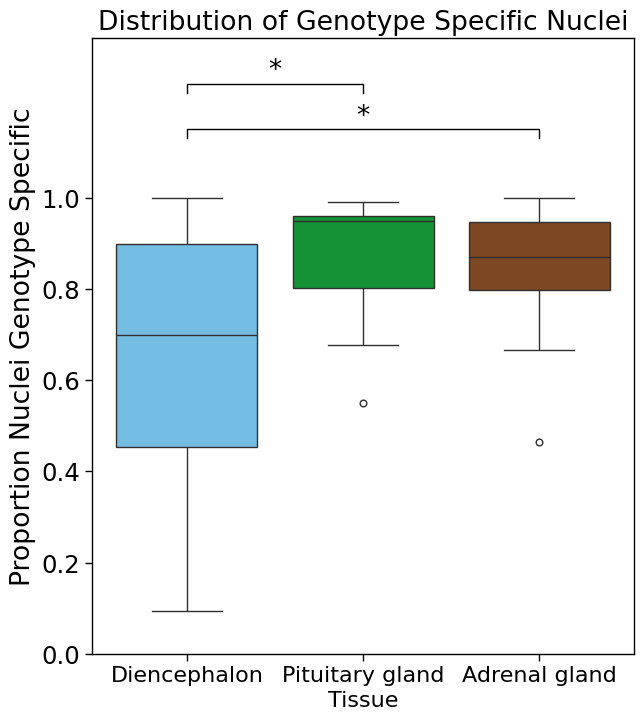

In [75]:

def add_significance_bars(ax, results_df, category_order, y_data_max):
    # Dictionary to convert p-values to asterisks
    sig_dict = {
        0.05: '*',
        0.01: '**',
        0.001: '***'
    }
    
    # Get the positions of the boxes on the x-axis
    category_positions = {cat: i for i, cat in enumerate(category_order)}
    
    # Calculate the maximum y value to start placing bars
    y_max = y_data_max * 1.15  
    bar_height = y_data_max * 0.1  
    used_positions = set()
    
    for _, row in results_df.iterrows():
        cat1, cat2 = row['Comparison'].split(' vs ')
        
        x1 = category_positions[cat1]
        x2 = category_positions[cat2]
        
        # add bar if significant 
        if row['P-Value'] < 0.05:
            if row['P-Value'] < 0.001:
                asterisks = '***'
            elif row['P-Value'] < 0.01:
                asterisks = '**'
            else:
                asterisks = '*'
            
            y_pos = y_max
            while y_pos in used_positions:
                y_pos += bar_height
            used_positions.add(y_pos)
            
            # Draw the bar
            bar_height_offset = y_data_max * 0.02  
            x_coords = [x1, x1, x2, x2]
            y_coords = [y_pos - bar_height_offset, y_pos, y_pos, y_pos - bar_height_offset]
            ax.plot(x_coords, y_coords, color='black', linewidth=1)
            
            # Add asterisks closer to the bar
            ax.text((x1 + x2) / 2, y_pos + (bar_height_offset/100000), 
                   asterisks, 
                   horizontalalignment='center',
                   verticalalignment='bottom')

plt.figure(figsize=(7, 8))
ax = sns.boxplot(
    data=prop_df_allct,
    x="tissue",
    y="prop",
    order=['Diencephalon', 'Pituitary gland', 'Adrenal gland'],
    palette=['#61C3F5', '#00A62C', '#8B4513']
)

for patch in ax.patches:
    patch.set_alpha(1)

ax.set_xticklabels(['Diencephalon', 'Pituitary gland', 'Adrenal gland'], fontsize = 16)
plt.xlabel("Tissue",fontsize = 16)
plt.ylabel("Proportion Nuclei Genotype Specific")
plt.title("Distribution of Genotype Specific Nuclei")

y_max = prop_df_allct['prop'].max()
add_significance_bars(ax, results_df, ['Diencephalon', 'Pituitary gland', 'Adrenal gland'], y_max)

plt.ylim(0, 1.35)  
# plt.yticks(np.arange(0, 1.6, 0.2))  
plt.yticks([0,0.2,0.4, 0.6,0.8,1.0])
plt.show()

# Figure 5b

<h3 id="Diencephalon-Pituitary-calculations">Diencephalon Pituitary GSI calculations</h3>

In [76]:
dienpit_pbulk = sc.read_h5ad(f'/share/crsp/lab/seyedam/share/igvf_pipeline/IGVF_analysis/pseudobulk_new/DiencephalonPituitary_pseudobulk.h5ad')
dienpit_pbulk1 = dienpit_pbulk.copy()

norm_counts = sc.pp.normalize_total(dienpit_pbulk1, target_sum=1e4,  inplace = False)['X'] # layer = 'cellbender_counts',
dienpit_pbulk1.layers['norm_counts'] = norm_counts

dienpit_pbulk_ct = dc.get_pseudobulk(
    dienpit_pbulk1,
    sample_col='Genotype',
    groups_col='subtype',
    layer='norm_counts',
    mode='mean',
    min_cells=0,
    min_counts=0
)

In [77]:
gene_celltype_matrix = pd.DataFrame(index=dienpit_pbulk_ct.var_names)

# Create an empty DataFrame to store celltype and frac_gsi05
gsiprop = pd.DataFrame(columns=['celltype', 'frac_gsi05'])

# Get celltypes where all genotypes (8) are represented
subtype_genotype_counts = dienpit_pbulk_ct.obs.groupby('subtype')['Genotype'].nunique()
celltypes = subtype_genotype_counts[subtype_genotype_counts == 8].index.tolist()

# Iterate over each unique celltype
for celltype in celltypes:
    # Get the gene expression data for the current celltype
    celltype_data = gsi(dienpit_pbulk_ct, celltype)
    
    # Merge the current celltype data into the gene_celltype_matrix by gene name
    gene_celltype_matrix = gene_celltype_matrix.merge(celltype_data, left_index=True, right_index=True, how='left')
    
    # Calculate the number of expressed genes and the fraction with GSI > 0.5
    numb_expressed = len(celltype_data)
    frac_gsi05 = sum((celltype_data > 0.5)[celltype]) / numb_expressed

    # Append the results to the gsiprop DataFrame
    gsiprop = pd.concat([
        gsiprop, 
        pd.DataFrame({'celltype': [celltype], 'frac_gsi05': [frac_gsi05]})
    ], ignore_index=True)


/tmp/ipykernel_2490776/2940755318.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gsiprop = pd.concat([


In [78]:
hpgsi = gsiprop.sort_values('frac_gsi05')
hpgsi['Tissue'] = hpgsi['celltype'].map(fullctmap)

### Adrenal GSI calculations

In [79]:
adrenal_pbulk1 = sc.read_h5ad('/share/crsp/lab/seyedam/share/igvf_pipeline/IGVF_analysis/pseudobulk_new/Adrenal_pseudobulk.h5ad')
adrenal_pbulk1.obs.replace('epiniphrine secreting chromaffin cell','epinephrine secreting chromaffin cell', inplace = True)

norm_counts = sc.pp.normalize_total(adrenal_pbulk1, target_sum=1e4,  inplace = False)['X'] # layer = 'cellbender_counts',
adrenal_pbulk1.layers['norm_counts'] = norm_counts

adrenal_pbulk_ct = dc.get_pseudobulk(
    adrenal_pbulk1,
    sample_col='Genotype',
    groups_col='subtype',
    layer='norm_counts',
    mode='mean',
    min_cells=0,
    min_counts=0
)

/tmp/ipykernel_2490776/3316493211.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adrenal_pbulk1.obs.replace('epiniphrine secreting chromaffin cell','epinephrine secreting chromaffin cell', inplace = True)


In [80]:
gene_celltype_matrix = pd.DataFrame(index=adrenal_pbulk_ct.var_names)

# Create an empty DataFrame to store celltype and frac_gsi05
asiprop = pd.DataFrame(columns=['celltype', 'frac_gsi05'])

# Get celltypes where all genotypes (8) are represented
subtype_genotype_counts = adrenal_pbulk_ct.obs.groupby('subtype')['Genotype'].nunique()
celltypes = subtype_genotype_counts[subtype_genotype_counts == 8].index.tolist()

# Iterate over each unique celltype
for celltype in celltypes:
    # Get the gene expression data for the current celltype
    celltype_data = gsi(adrenal_pbulk_ct, celltype)
    
    # Merge the current celltype data into the gene_celltype_matrix by gene name
    gene_celltype_matrix = gene_celltype_matrix.merge(celltype_data, left_index=True, right_index=True, how='left')
    
    # Calculate the number of expressed genes and the fraction with GSI > 0.5
    numb_expressed = len(celltype_data)
    frac_gsi05 = sum((celltype_data > 0.5)[celltype]) / numb_expressed

    # Append the results to the gsiprop DataFrame
    asiprop = pd.concat([
        asiprop, 
        pd.DataFrame({'celltype': [celltype], 'frac_gsi05': [frac_gsi05]})
    ], ignore_index=True)
agsi = asiprop.sort_values('frac_gsi05')

agsi['Tissue'] = 'Adrenal gland'

/tmp/ipykernel_2490776/621600281.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  asiprop = pd.concat([


### Merged

In [81]:
hpagsi = pd.concat([agsi, hpgsi], axis = 0)

hpagsi['pct_gsi05'] = hpagsi['frac_gsi05']*100

hpagsi.sort_values('frac_gsi05', ascending = True, inplace= True)

In [82]:
hypopitmeta = pd.read_csv('/share/crsp/lab/seyedam/weberrl/IGVF_analysis/Hypothalamus_pituitary_new_cb/dienceophalonpituitary_metadata.csv')
adrenalmeta = pd.read_csv('/share/crsp/lab/seyedam/weberrl/IGVF_analysis/Hypothalamus_pituitary_new_cb/adrenal_metadata.csv')

hypopitmeta = hypopitmeta[hypopitmeta['subtype'] != 'low quality']
adrenalmeta = adrenalmeta[adrenalmeta['subtype'] != 'low quality']

adrenal_ct_c = adrenalmeta['subtype'].value_counts().reset_index()
hypopit_ct_c = hypopitmeta['subtype'].value_counts().reset_index()

adrenal_ct_c['Tissue'] = 'Adrenal gland'

hypopit_ct_c['Tissue'] = hypopit_ct_c['subtype'].map(fullctmap)

adrenal_ct_c.replace({'endothelial cell': 'endothelial cell-Adrenal',
                     'epiniphrine secreting chromaffin cell':'epinephrine secreting chromaffin cell'}, inplace = True)
hypopit_ct_c.replace('endothelial cell','endothelial cell-Diencephalon_Pituitary', inplace = True)
ct_count_df = pd.concat([adrenal_ct_c,hypopit_ct_c], axis = 0)
ct_count_df['ct_num'] = (ct_count_df['count'] / 1000).round(1).astype(str) + 'K'


hpagsi.reset_index(inplace = True)
hpagsi.loc[[10, 15], 'celltype'] = ['endothelial cell-Diencephalon_Pituitary', 'endothelial cell-Adrenal']
mdf = pd.merge(hpagsi, ct_count_df, left_on = 'celltype', right_on = 'subtype')
mdf.rename(columns = {'Tissue_x':'Tissue'}, inplace = True)

/tmp/ipykernel_2490776/1836487930.py:1: DtypeWarning: Columns (24,27,28,29,30,33) have mixed types. Specify dtype option on import or set low_memory=False.
  hypopitmeta = pd.read_csv('/share/crsp/lab/seyedam/weberrl/IGVF_analysis/Hypothalamus_pituitary_new_cb/dienceophalonpituitary_metadata.csv')


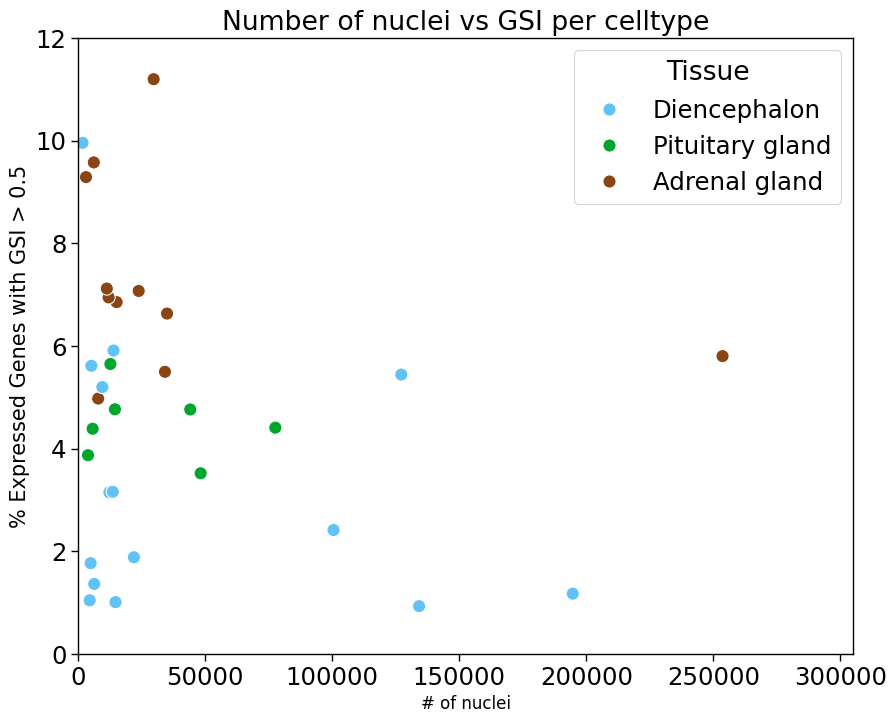

In [83]:
tissue_palette = {
    'Diencephalon': '#61C3F5',
    'Pituitary gland': '#00A62C',
    'Adrenal gland': '#8B4513'
}

plt.figure(figsize=(10, 8))  
sns.scatterplot(data=mdf, x='count', y='pct_gsi05', hue='Tissue', s=90, palette=tissue_palette)

plt.xlabel('# of nuclei', fontsize=12)  # Smaller font size for x-axis label
plt.ylabel('% Expressed Genes with GSI > 0.5', fontsize=15)  # Smaller font size for y-axis label

plt.title('Number of nuclei vs GSI per celltype')

plt.xlim(0,305000)
plt.ylim(0,12)


plt.show()


# Figure 5c

In [84]:
gene_table = pd.read_csv('/share/crsp/lab/seyedam/weberrl/IGVF_analysis/Hypothalamus_Pituitary/topyfic/gene_display_table.csv')

tf = gene_table[gene_table['cat_biotype'] == 'Transcription Factor']['gene_name']




### Diencephalon pituitary

In [85]:
dp_pbdata = dienpit_pbulk_ct.copy()
dp_pbdata = dp_pbdata[dp_pbdata.obs['subtype']!= 'low quality']

gene_celltype_matrix = pd.DataFrame(index=dp_pbdata.var_names)

subtype_genotype_counts = dp_pbdata.obs.groupby('subtype')['Genotype'].nunique()
celltypes = subtype_genotype_counts[subtype_genotype_counts == 8].index.tolist()

# Iterate over each unique celltype
for celltype in celltypes:
    celltype_data = gsi(dp_pbdata, celltype)
    gene_celltype_matrix = gene_celltype_matrix.merge(celltype_data, left_index=True, right_index=True, how='left')
    
gene_celltype_matrix.rename(columns = {'endothelial cell':'endothelial cell-Diencephalon_Pituitary'}, inplace = True)


combined_stats = pd.DataFrame()

# Iterate over cell types in the matrix
for ct in gene_celltype_matrix.columns:

    ######################################################################
    testdf = gene_celltype_matrix[[ct]].dropna()
    subgenm = testdf[ct].reset_index()
    gene_table2 = gene_table[['display_name', 'cat_biotype']]
    gt_dict = gene_table2.set_index('display_name').to_dict()['cat_biotype']

    subgenm['cat_biotype'] = subgenm['gene_name'].map(gt_dict).fillna('non_regulatory')
    pldf = subgenm
    
    
#     # Generate KDE plot
#     ax = sns.kdeplot(data=pldf, x=ct, bw_adjust=1, hue='cat_biotype',common_norm=False)
#     sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#     plt.xlabel(f"{ct} GSI")
#     plt.title(f"{ct}")
#     # plt.tight_layout()
#     plt.show()
    
    # Compute descriptive statistics
    stats = (
        pldf.groupby('cat_biotype')[ct]
        .describe()['50%']
        .reset_index()
        .rename(columns={'50%': ct})
        .set_index('cat_biotype')  # Set index for merging
    )
    
    # Merge statistics into the combined DataFrame
    if combined_stats.empty:
        combined_stats = stats
    else:
        combined_stats = combined_stats.join(stats, how='outer')

# Reset the index for the final output
combined_stats = combined_stats.reset_index()


median_gsi_typeDP = combined_stats.set_index('cat_biotype').T.apply(zscore, axis=1, result_type='expand')[['Histone Modifying Enzyme','Chromatin Binding','TAF-Mediator',
                                                                                       'Chromatin Organization','Transcription Regulator','Transcription Factor','non_regulatory']].apply(zscore, axis=1, result_type='expand')

In [86]:
biotypes_to_test = ['Transcription Regulator', 'Transcription Factor', 
                    'Chromatin Organization', 'Chromatin Binding', 
                    'Histone Modifying Enzyme', 'TAF-Mediator']

ks_results = {}

# Perform the KS tests
for ct in gene_celltype_matrix.columns:
    testdf = gene_celltype_matrix[[ct]].dropna()
    subgenm = testdf[ct].reset_index()
    gene_table2 = gene_table[['display_name', 'cat_biotype']]
    gt_dict = gene_table2.set_index('display_name').to_dict()['cat_biotype']

    subgenm['cat_biotype'] = subgenm['gene_name'].map(gt_dict).fillna('non_regulatory')
    pldf = subgenm

    non_regulatory_values = pldf[pldf['cat_biotype'] == 'non_regulatory'][ct]

    # Store the results for each cell type
    biotype_results = {}

    for biotype in biotypes_to_test:
        other_values = pldf[pldf['cat_biotype'] == biotype][ct]

        # Perform the Kolmogorov-Smirnov test
        ks_stat, p_value = ks_2samp(non_regulatory_values, other_values)

        # Check p-value
        biotype_results[biotype] = p_value < 0.05

    # Store the results for the current cell type in the dictionary
    ks_results[ct] = biotype_results

ks_results_df = pd.DataFrame(ks_results).T  # Transpose to have cell types as rows
ks_results_df2 = ks_results_df[median_gsi_typeDP.columns[:6]]
median_gsi_type_nononreg = median_gsi_typeDP.drop('non_regulatory', axis = 1)

median_gsi_type_nononreg_DienPit = median_gsi_type_nononreg
ks_results_df2_DienPit = ks_results_df2

### Adrenal

In [87]:
ad_pbdata = adrenal_pbulk_ct.copy()
ad_pbdata = ad_pbdata[ad_pbdata.obs['subtype']!= 'low quality']


In [88]:
gene_celltype_matrix = pd.DataFrame(index=ad_pbdata.var_names)

subtype_genotype_counts = ad_pbdata.obs.groupby('subtype')['Genotype'].nunique()
celltypes = subtype_genotype_counts[subtype_genotype_counts == 8].index.tolist()

# Iterate over each unique celltype
for celltype in celltypes:
    # Get the gene expression data for the current celltype
    celltype_data = gsi(ad_pbdata, celltype)
    
    # Merge the current celltype data into the gene_celltype_matrix by gene name
    gene_celltype_matrix = gene_celltype_matrix.merge(celltype_data, left_index=True, right_index=True, how='left')


In [89]:
combined_stats = pd.DataFrame()

# Iterate over cell types in the matrix
for ct in gene_celltype_matrix.columns:

    ######################################################################
    testdf = gene_celltype_matrix[[ct]].dropna()
    subgenm = testdf[ct].reset_index()
    gene_table2 = gene_table[['display_name', 'cat_biotype']]
    gt_dict = gene_table2.set_index('display_name').to_dict()['cat_biotype']

    subgenm['cat_biotype'] = subgenm['gene_name'].map(gt_dict).fillna('non_regulatory')
    pldf = subgenm
    
    # Compute descriptive statistics
    stats = (
        pldf.groupby('cat_biotype')[ct]
        .describe()['50%']
        .reset_index()
        .rename(columns={'50%': ct})
        .set_index('cat_biotype')  # Set index for merging
    )
    
    # Merge statistics into the combined DataFrame
    if combined_stats.empty:
        combined_stats = stats
    else:
        combined_stats = combined_stats.join(stats, how='outer')

combined_stats = combined_stats.reset_index()


median_gsi_typeAD = combined_stats.set_index('cat_biotype').T.apply(zscore, axis=1, result_type='expand')[['Histone Modifying Enzyme','Chromatin Binding','TAF-Mediator',
                                                                                       'Chromatin Organization','Transcription Regulator','Transcription Factor','non_regulatory']].apply(zscore, axis=1, result_type='expand')
                

In [90]:

# Initialize an empty dictionary to store results
ks_results = {}

# Perform the KS tests
for ct in gene_celltype_matrix.columns:
    testdf = gene_celltype_matrix[[ct]].dropna()
    subgenm = testdf[ct].reset_index()
    gene_table2 = gene_table[['display_name', 'cat_biotype']]
    gt_dict = gene_table2.set_index('display_name').to_dict()['cat_biotype']

    subgenm['cat_biotype'] = subgenm['gene_name'].map(gt_dict).fillna('non_regulatory')
    pldf = subgenm

    # Split the data into 'non_regulatory' values
    non_regulatory_values = pldf[pldf['cat_biotype'] == 'non_regulatory'][ct]

    # Store the results for each cell type
    biotype_results = {}

    for biotype in biotypes_to_test:
        other_values = pldf[pldf['cat_biotype'] == biotype][ct]

        # Perform the Kolmogorov-Smirnov test
        ks_stat, p_value = ks_2samp(non_regulatory_values, other_values)

        biotype_results[biotype] = p_value < 0.05
    ks_results[ct] = biotype_results

ks_results_df = pd.DataFrame(ks_results).T  # Transpose to have cell types as rows

ks_results_df2 = ks_results_df[median_gsi_typeAD.columns[:6]]
ks_results_df2_AD = ks_results_df2
median_gsi_type_nononreg = median_gsi_typeAD.drop('non_regulatory', axis = 1)
median_gsi_type_nononreg_AD = median_gsi_type_nononreg


In [91]:
median_gsi_type_nononreg_hpa = pd.concat([median_gsi_type_nononreg_DienPit,median_gsi_type_nononreg_AD], axis = 0)
median_gsi_typeHPA = pd.concat([median_gsi_typeDP,median_gsi_typeAD], axis = 0)
ks_results_df2_hpa = pd.concat([ks_results_df2_DienPit, ks_results_df2_AD], axis = 0)

/home/jovyan/.local/lib/python3.10/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(**tight_params)


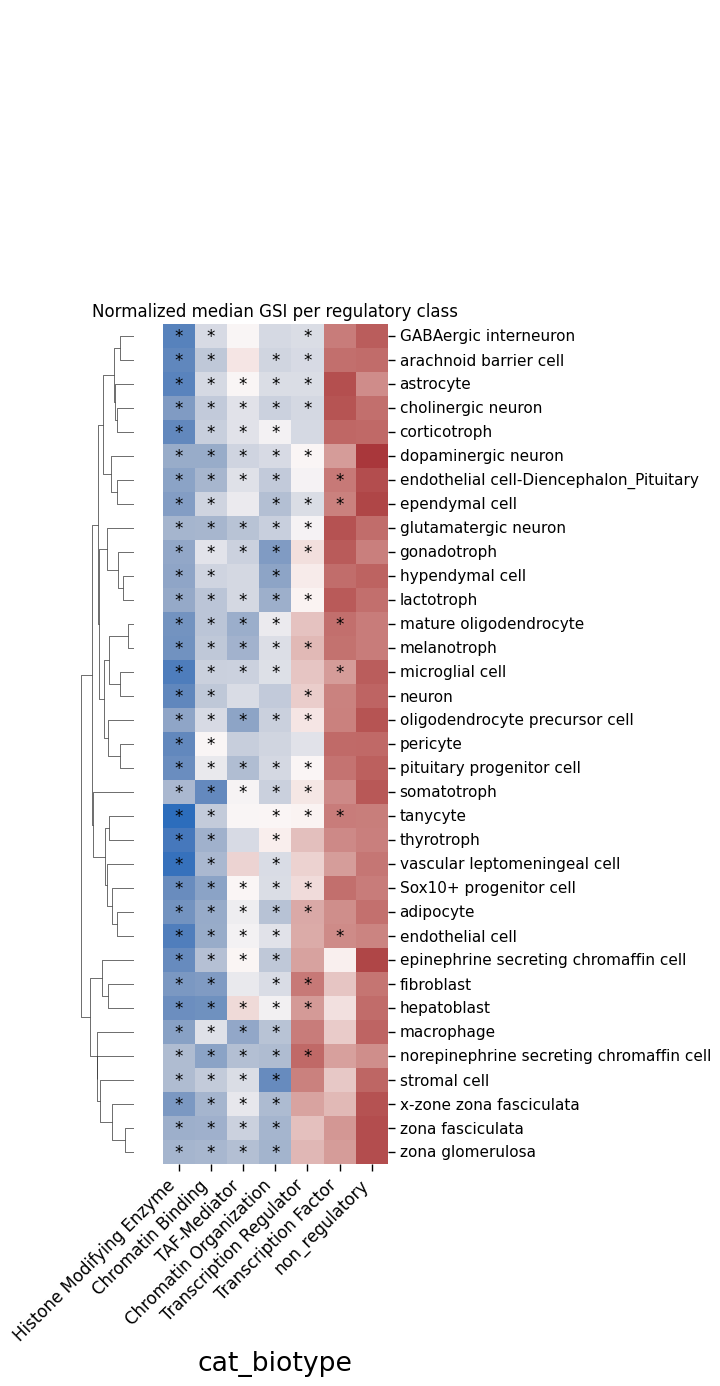

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Create the clustermap
g = sns.clustermap(
    median_gsi_typeHPA,
    cmap='vlag',
    center=0,
    row_cluster=True,
    col_cluster=False,
    figsize=(4, 15),
    cbar=False  # Removes the colorbar
)

g.cax.remove()

# Get the positions of significant values
for i, row in enumerate(median_gsi_type_nononreg_hpa.index):  # Iterate through rows
    for j, col in enumerate(median_gsi_type_nononreg_hpa.columns[:6]):  # Iterate through first 6 columns
        if ks_results_df2_hpa.loc[row, col]:  # Check if the cell is significant
            g.ax_heatmap.text(
                j + 0.5, i + 0.5, '*',  # Column index, row index
                color='black', ha='center', va='center', fontsize=12
            )

# Ensure all y-axis labels are shown and aligned
y_positions = np.arange(len(median_gsi_typeHPA.index)) + 0.5  # Align with heatmap cells
g.ax_heatmap.set_yticks(y_positions)
g.ax_heatmap.set_yticklabels(
    median_gsi_typeHPA.index,
    fontsize=11,
    rotation=0,
    va='center',
)

# Adjust x-axis font size and rotation
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), fontsize=12, rotation=45, ha='right')
plt.title('Normalized median GSI per regulatory class', fontsize = 12)
plt.show()

# Figure 5d

In [93]:
# Create an empty DataFrame to store the gene-by-celltype matrix
gene_celltype_matrix_hp = pd.DataFrame(index=dienpit_pbulk_ct.var_names)

subtype_genotype_counts = dienpit_pbulk_ct.obs.groupby('subtype')['Genotype'].nunique()
celltypes = subtype_genotype_counts[subtype_genotype_counts == 8].index.tolist()

# Iterate over each unique celltype
for celltype in celltypes:
    celltype_data = gsi(dienpit_pbulk_ct, celltype)
    gene_celltype_matrix_hp = gene_celltype_matrix_hp.merge(celltype_data, left_index=True, right_index=True, how='left')

gene_celltype_matrix_hp = gene_celltype_matrix_hp.fillna(0)
boolean_df_hp = gene_celltype_matrix_hp > gsi_cutoff

pitboo = boolean_df_hp[['lactotroph','corticotroph','somatotroph','melanotroph','gonadotroph','thyrotroph']]
pituitary_GSI05 = boolean_df_hp[['lactotroph','corticotroph','somatotroph','melanotroph','gonadotroph','thyrotroph']][boolean_df_hp[['lactotroph','corticotroph','somatotroph','melanotroph','gonadotroph','thyrotroph']].any(axis = 1)].index


pit_pb = dienpit_pbulk_ct[dienpit_pbulk_ct.obs['subtype'].isin(['lactotroph','corticotroph','somatotroph','melanotroph','gonadotroph','thyrotroph'])]

pit_gsi05 = pit_pb.to_df()[pituitary_GSI05].T

# pit_gsi05_zscore = pit_gsi05.apply(zscore, axis=1)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))  # Define scaler with range (-1, 1)
# Apply row-wise normalization
normalized_pit_gsi05 = pit_gsi05.apply(lambda row: scaler.fit_transform(row.values.reshape(-1, 1)).flatten(), axis=1)
# Convert back to a DataFrame (if needed)
pit_gsi05_norm = pd.DataFrame(normalized_pit_gsi05.tolist(), index=pit_gsi05.index, columns=pit_gsi05.columns)


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..


/home/jovyan/.local/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:860: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jovyan/.local/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:860: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 51.429333333333346 mm


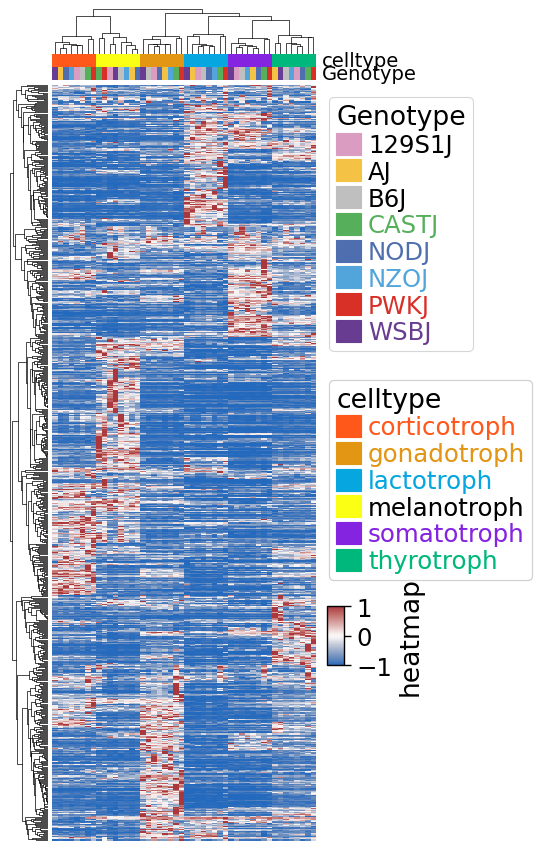

In [94]:
split_col = pit_gsi05_norm.columns.str.split('_')

col_df = pd.DataFrame(split_col.tolist(), columns = ['Genotype','subtype'])

col_df.index = col_df['Genotype'].astype(str) + '_' + col_df['subtype'].astype(str)
col_df.head(3)
sex_dict = {
    'Male': 'dodgerblue',  
    'Female': 'hotpink'    
}


geno_dict = {
    '129S1J': '#DA9CC1',  
    'AJ': '#F4C245',             
    'B6J': '#C0BFBF',               
    'CASTJ': '#55AF5B',  
    'NODJ': '#4F6EAF',        
    'NZOJ': '#52A5DB',              
    'PWKJ': '#D83026',        
    'WSBJ': '#683C91'   
}

celltype_dict = {
    'corticotroph':'#FF581A',
    'gonadotroph':'#E29614',
    'lactotroph':'#06A6E1',
    'melanotroph':'#FAFF14',
    'somatotroph':'#8524E0',
    'thyrotroph':'#01B87C'
}

plt.figure(figsize=(4, 9.5))

col_ha = pch.HeatmapAnnotation(celltype = pch.anno_simple(col_df['subtype'], colors = celltype_dict),
                               Genotype = pch.anno_simple(col_df['Genotype'], colors = geno_dict),
                               verbose = 1, axis = 1,
                               plot_legend = True,
                               label_kws={'fontsize':14}
                              )
                               


cm = pch.ClusterMapPlotter(data=pit_gsi05_norm,
                          cmap='vlag',
                          show_rownames = False, 
                          top_annotation=col_ha, 
                          row_dendrogram = True,
                          col_dendrogram = True,
                          legend_order = ['Genotype','celltype','heatmap'],
                          legend_gap = 8,

                          )

plt.show()

# Figure 5e

In [95]:
sex_palette = {'Male': 'dodgerblue', 'Female': 'hotpink'}
genotype_order = ['AJ','B6J','129S1J','NODJ','NZOJ','CASTJ','PWKJ','WSBJ']
geno_dict = {
    '129S1J': '#DA9CC1',  
    'AJ': '#F4C245',             
    'B6J': '#C0BFBF',               
    'CASTJ': '#55AF5B',  
    'NODJ': '#4F6EAF',        
    'NZOJ': '#52A5DB',              
    'PWKJ': '#D83026',        
    'WSBJ': '#683C91'   
}


sns.set_theme(style="whitegrid")

dpadata = sc.read_h5ad(f'/share/crsp/lab/seyedam/share/igvf_pipeline/IGVF_analysis/pseudobulk_new/DiencephalonPituitary_pseudobulk.h5ad')
sc.pp.normalize_total(dpadata, target_sum=1e6)

des_res = pd.read_csv('/share/crsp/lab/seyedam/share/igvf_pipeline/figures/degs/DiencephalonPituitary/results_de_analysis.csv')


des_res[['genotype1', 'genotype2']] = des_res['comparison'].str.extract(r'^[^_]+_([^_]+)_[^_]+_([^_]+)')
des_res_tropes = des_res[des_res['celltype'].isin(['somatotroph','corticotroph','lactotroph','melanotroph','thyrotroph','gonadotroph'])]
des_res_tropes_sig = des_res_tropes[(des_res_tropes['padj'] < 0.01) & (abs(des_res_tropes['log2FoldChange'])>1)]
filtered_df = des_res_tropes_sig[(des_res_tropes_sig['genotype1'] == 'B6J') | (des_res_tropes_sig['genotype2'] == 'B6J')]

adjusted_df = filtered_df.copy()
switch_rows = adjusted_df['genotype1'] == 'B6J'
adjusted_df.loc[switch_rows, ['genotype1', 'genotype2']] = adjusted_df.loc[switch_rows, ['genotype2', 'genotype1']].values
adjusted_df.loc[switch_rows, 'log2FoldChange'] *= -1


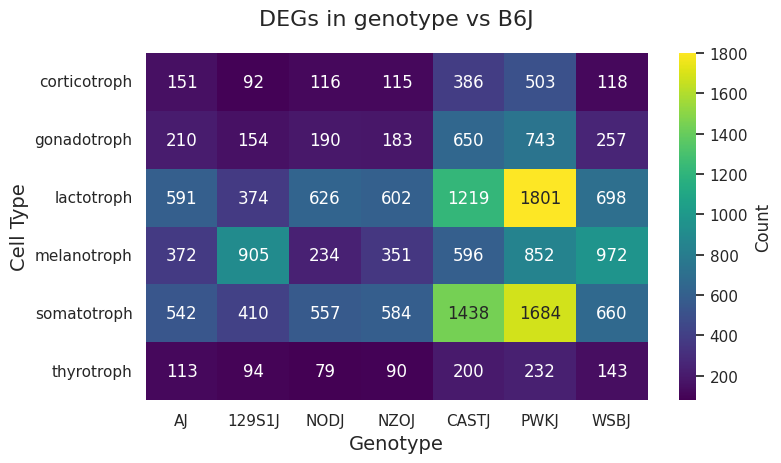

In [96]:
deg_counts = adjusted_df.groupby('celltype')['genotype1'].value_counts().reset_index(name='count').pivot(index='celltype', columns='genotype1', values='count').fillna(0)
deg_counts = deg_counts[['AJ','129S1J','NODJ','NZOJ','CASTJ','PWKJ','WSBJ']]


plt.figure(figsize=(7, 4.4))

# Create the heatmap with annotations and titles
sns.heatmap(deg_counts, cmap="viridis", annot=True, fmt="g", cbar_kws={'label': 'Count'})

# Add titles and axis labels
plt.title("DEGs in genotype vs B6J", fontsize=16, pad=20)
plt.xlabel("Genotype", fontsize=14)
plt.ylabel("Cell Type", fontsize=14)

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()


# Figure 5f

In [97]:
def plot_gene(dpadata, gene, celltype, sex=False):
    plt.figure(figsize=(9, 6.5))
    dpadata_sub = dpadata[dpadata.obs['subtype'] == celltype]
    pb_df = sc.get.obs_df(dpadata_sub, ['Genotype','Sex',gene])
    if sex==False:
        sns.violinplot(data=pb_df, x='Genotype', y=gene, inner=None, cut=0, scale='width', order=genotype_order,
                       palette=geno_dict, legend=None)

        sns.stripplot(data=pb_df, x='Genotype', y=gene, 
                      color='black', size=4, jitter=True, alpha=0.7, dodge=True, order=genotype_order, legend=None)
    
    plt.title(f'{gene}', fontsize=16)

    # Make axis labels larger
    plt.xlabel('', fontsize=16)
    plt.ylabel(f'{gene} Expression (RPM)', fontsize=16)
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    # Show the plot
    plt.show()


/tmp/ipykernel_2490776/3662201955.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=pb_df, x='Genotype', y=gene, inner=None, cut=0, scale='width', order=genotype_order,
/tmp/ipykernel_2490776/3662201955.py:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=pb_df, x='Genotype', y=gene, inner=None, cut=0, scale='width', order=genotype_order,


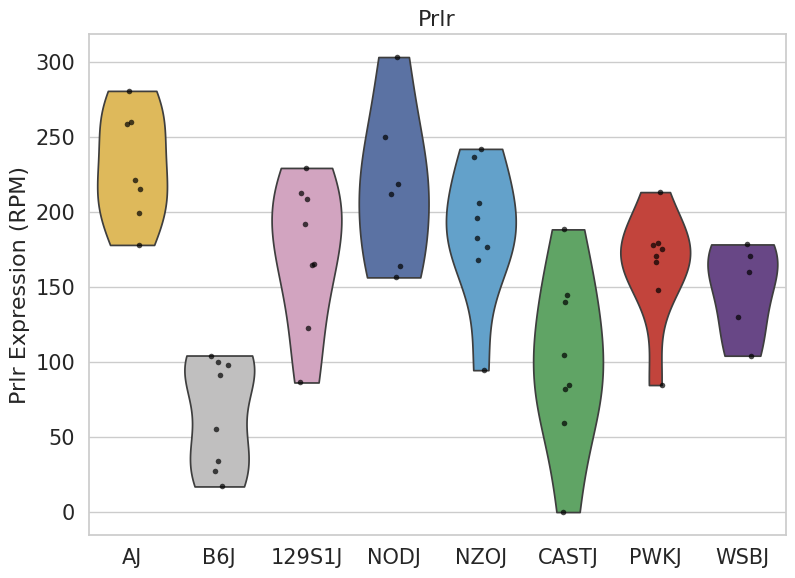

In [98]:
plot_gene(dpadata, 'Prlr', 'corticotroph')

/tmp/ipykernel_2490776/3662201955.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=pb_df, x='Genotype', y=gene, inner=None, cut=0, scale='width', order=genotype_order,
/tmp/ipykernel_2490776/3662201955.py:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=pb_df, x='Genotype', y=gene, inner=None, cut=0, scale='width', order=genotype_order,


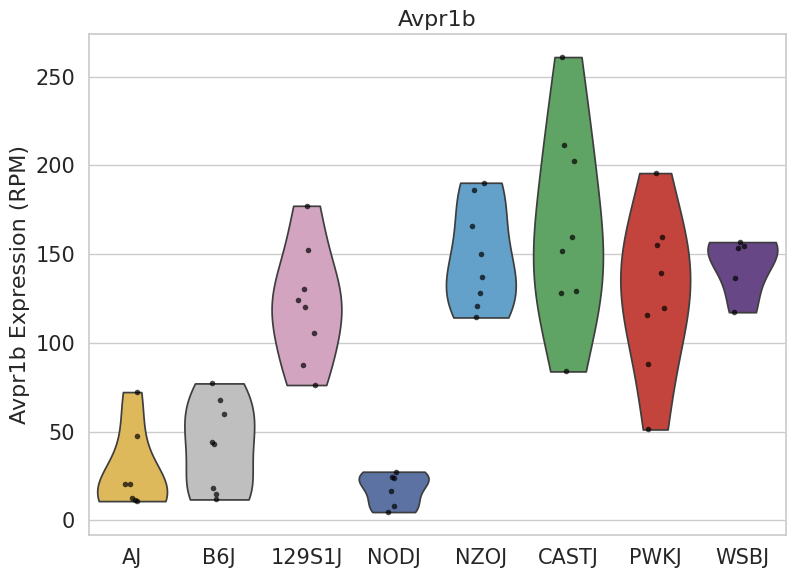

In [99]:
plot_gene(dpadata, 'Avpr1b', 'corticotroph')